<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
# Import all necessary modules
import numpy as np
import pandas as pd
import gensim
import os, sys, re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import spacy
nlp = spacy.load('en_core_web_lg')

/anaconda3/envs/u4s1env/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/anaconda3/envs/u4s1env/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/anaconda3/envs/u4s1env/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [3]:
# Load dataset
df = pd.read_csv("./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

In [4]:
# Clean data

# tokenize and remove stopwords
tokenized_reviews = [[token for token in simple_preprocess(review) if token not in STOPWORDS] \
                      for review in df['reviews.text']]

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[tokenized_reviews], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tokenized_reviews[0]]])

['order', 'item', 'bad', 'quality', 'missing', 'backup', 'spring', 'pcs', 'aluminum', 'battery', 'work']


In [6]:
# Useful functions

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
tokenized_reviews_bigrams = make_bigrams(tokenized_reviews)

tokenized_reviews_lemmatized = lemmatization(tokenized_reviews_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(tokenized_reviews_lemmatized[:1])

[['order', 'item', 'bad', 'quality', 'miss', 'backup', 'spring', 'pcs', 'aluminum', 'battery', 'work']]


In [8]:
df['reviews.tokenized'] = pd.Series(tokenized_reviews)

In [9]:
# Create dict/corpus for topic modeling

def get_reviews(df, token_col):

    assert token_col in df.columns, f"{token_col} does not exist!"
    
    for index, row in df.iterrows():
        review_token = row[token_col]
        yield review_token

In [10]:
# construct a dictionary of tokenized words with their respective ids
id2word = corpora.Dictionary(get_reviews(df, 'reviews.tokenized'))

In [11]:
# Bag of words to LDA
corpus = [id2word.doc2bow(review) for review in get_reviews(df, 'reviews.tokenized')]

lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=42, # random state for multicore doesnt work in gensim
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [12]:
lda.print_topics()

[(0,
  '0.043*"kindle" + 0.026*"screen" + 0.026*"read" + 0.025*"reading" + 0.021*"light" + 0.021*"size" + 0.019*"use" + 0.019*"easy" + 0.018*"reader" + 0.014*"love"'),
 (1,
  '0.063*"buy" + 0.040*"great" + 0.032*"price" + 0.025*"batteries" + 0.019*"money" + 0.019*"purchase" + 0.018*"recommend" + 0.018*"amazon" + 0.018*"definitely" + 0.017*"good"'),
 (2,
  '0.035*"wifi" + 0.026*"internet" + 0.019*"apps" + 0.015*"tablet" + 0.010*"amazon" + 0.010*"bought" + 0.010*"laptop" + 0.010*"advertised" + 0.010*"gift" + 0.009*"use"'),
 (3,
  '0.032*"long" + 0.032*"ok" + 0.024*"battery" + 0.021*"lasts" + 0.019*"pretty" + 0.014*"like" + 0.014*"charge" + 0.013*"holds" + 0.012*"difference" + 0.011*"slow"'),
 (4,
  '0.083*"tablet" + 0.034*"great" + 0.024*"amazon" + 0.023*"apps" + 0.022*"good" + 0.020*"price" + 0.016*"kids" + 0.014*"google" + 0.013*"screen" + 0.013*"play"'),
 (5,
  '0.073*"kids" + 0.044*"love" + 0.039*"games" + 0.035*"tablet" + 0.023*"apps" + 0.021*"great" + 0.017*"amazon" + 0.015*"kid" +

In [13]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [14]:
topics = [' '.join(t[0:5]) for t in words]

In [16]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id + 1} ------")
    print(t, end="\n\n")

------ Topic 1 ------
kindle screen read reading light

------ Topic 2 ------
buy great price batteries money

------ Topic 3 ------
wifi internet apps tablet amazon

------ Topic 4 ------
long ok battery lasts pretty

------ Topic 5 ------
tablet great amazon apps good

------ Topic 6 ------
kids love games tablet apps

------ Topic 7 ------
batteries good price great long

------ Topic 8 ------
kindle new like tablet love

------ Topic 9 ------
love best tablets buy amazon

------ Topic 10 ------
great works books read alexa

------ Topic 11 ------
charge tablet charging charger device

------ Topic 12 ------
battery life amazon use product

------ Topic 13 ------
loves old year bought tablet

------ Topic 14 ------
box amazon come use batteries

------ Topic 15 ------
great good tablet price use



In [17]:
# Interpret LDA results
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [18]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/anaconda3/envs/u4s1env/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.234914  0.139907       1        1  16.085403
12    -0.220598 -0.027058       2        1  11.626094
4     -0.097756  0.131900       3        1   9.398222
14    -0.100616  0.215737       4        1   8.734363
0     -0.112650 -0.050214       5        1   7.076648
7     -0.150394 -0.044531       6        1   6.556195
1      0.173443  0.141481       7        1   6.247605
5     -0.191188  0.025132       8        1   5.563001
13     0.092560 -0.128534       9        1   5.400524
11     0.139009 -0.076695      10        1   5.271432
10     0.045633 -0.155027      11        1   4.710086
9     -0.004436  0.063379      12        1   4.310335
8      0.018471 -0.096470      13        1   3.332772
3      0.212770 -0.039972      14        1   2.881878
2     -0.039162 -0.099035      15        1   2.805439, topic_info=     Category         Freq         Term        Total  loglift  logprob
19    Default  7176.000000    batteries  7176.000000  30.0000  30.0000
93    Default  3565.000000         love  3565.000000  29.0000  29.0000
4196  Default  6720.000000       tablet  6720.000000  28.0000  28.0000
22    Default  8918.000000        great  8918.000000  27.0000  27.0000
2616  Default  2029.000000        loves  2029.000000  26.0000  26.0000
3     Default  2101.000000      battery  2101.000000  25.0000  25.0000
3156  Default  2962.000000       kindle  2962.000000  24.0000  24.0000
202   Default  2539.000000         kids  2539.000000  23.0000  23.0000
18    Default  4882.000000        price  4882.000000  22.0000  22.0000
605   Default  2022.000000          old  2022.000000  21.0000  21.0000
30    Default  2302.000000          buy  2302.000000  20.0000  20.0000
24    Default  2398.000000         long  2398.000000  19.0000  19.0000
35    Default  5750.000000         good  5750.000000  18.0000  18.0000
108   Default  1698.000000         year  1698.000000  17.0000  17.0000
772   Default  1712.000000        games  1712.000000  16.0000  16.0000
61    Default  1054.000000         life  1054.000000  15.0000  15.0000
99    Default  1464.000000        works  1464.000000  14.0000  14.0000
902   Default  2885.000000         easy  2885.000000  13.0000  13.0000
935   Default  1335.000000         read  1335.000000  12.0000  12.0000
3172  Default  1595.000000        books  1595.000000  11.0000  11.0000
2050  Default  1827.000000         apps  1827.000000  10.0000  10.0000
2245  Default  1631.000000       screen  1631.000000   9.0000   9.0000
174   Default  1869.000000      product  1869.000000   8.0000   8.0000
235   Default  1479.000000         best  1479.000000   7.0000   7.0000
10    Default  2273.000000         work  2273.000000   6.0000   6.0000
29    Default  3073.000000       bought  3073.000000   5.0000   5.0000
5710  Default   777.000000      tablets   777.000000   4.0000   4.0000
21    Default  1185.000000        brand  1185.000000   3.0000   3.0000
1059  Default  1023.000000         gift  1023.000000   2.0000   2.0000
1145  Default  1229.000000      reading  1229.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
2235  Topic15   229.786560     internet   520.254944   2.7564  -3.6627
6975  Topic15    19.767944        skype    26.208082   3.2916  -6.1158
1802  Topic15    71.968666     returned   133.416763   2.9564  -4.8236
1946  Topic15    29.999374     material    45.153351   3.1647  -5.6987
1997  Topic15    44.662426       picked    77.164398   3.0268  -5.3007
919   Topic15    56.630630      helpful   108.080223   2.9273  -5.0633
1387  Topic15    55.128891      connect   110.011292   2.8827  -5.0902
276   Topic15    66.329765       update   147.394592   2.7751  -4.9052
1889  Topic15    90.104950       laptop   235.910645   2.6111  -4.5989
1371  Topic15    47.023899       person   100.945099   2.8097  -5.2492
720   Topic15    59.522614       priced   145.172455   2.

In [19]:
# Coherence score - the higher the better
cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
print(f'Coherence score: {cm.get_coherence()}')

Coherence score: -3.324769671485807


In [21]:
# Find optimal topics for LDA
def compute_coherence_values(dictionary, corpus, df, token_col, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    
    tokens = list(get_reviews(df, token_col))
    
    # for iter_ in range(passes):
    for num_topics in range(start, limit, step):
        stream = get_reviews(df, token_col)
        model = LdaMulticore(corpus=corpus, 
                             num_topics=num_topics, 
                             id2word=dictionary, 
                             workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=df[token_col], 
                                        dictionary=dictionary, 
                                        corpus=corpus, 
                                        coherence='c_v')
        coherence_values.append({
            'num_topics': num_topics,
            'coherence_score': coherencemodel.get_coherence()
                                })

    return model_list, coherence_values

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        df=df, 
                                                        token_col='reviews.tokenized', 
                                                        start=2, 
                                                        limit=14)

In [23]:
len(coherence_values), len(model_list)

(4, 4)

In [24]:
coherence_values[0]

{'num_topics': 2, 'coherence_score': 0.26833582197642963}

In [25]:
cv_list = [d['coherence_score'] for d in coherence_values]

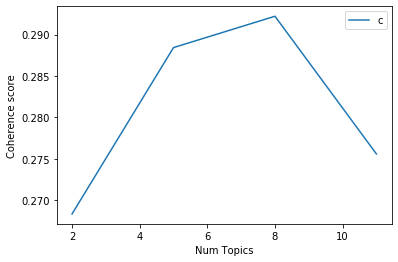

In [26]:
# plot cv
limit=14
start=2
step=3;
x = range(start, limit, step)
plt.plot(x,  cv_list)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print coherence scores
for m, cv in zip(x, cv_list):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2683
Num Topics = 5  has Coherence Value of 0.2884
Num Topics = 8  has Coherence Value of 0.2922
Num Topics = 11  has Coherence Value of 0.2756


In [28]:
best_lda = model_list[2]

In [29]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_lda, corpus, id2word)

/anaconda3/envs/u4s1env/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.002525 -0.000473       1        1  19.382830
4      0.009037 -0.069203       2        1  15.856915
3     -0.098468  0.007231       3        1  15.219143
6      0.110741  0.044225       4        1  13.877355
0      0.047268 -0.047561       5        1  11.852093
5     -0.024342 -0.024588       6        1   9.006822
1     -0.020292  0.021214       7        1   8.329307
2     -0.021419  0.069156       8        1   6.475531, topic_info=     Category         Freq        Term        Total  loglift  logprob
4196  Default  7886.000000      tablet  7886.000000  30.0000  30.0000
3156  Default  3058.000000      kindle  3058.000000  29.0000  29.0000
19    Default  7358.000000   batteries  7358.000000  28.0000  28.0000
2245  Default  1827.000000      screen  1827.000000  27.0000  27.0000
2050  Default  1849.000000        apps  1849.000000  26.0000  26.0000
22    Default  8938.000000       great  8938.000000  25.0000  25.0000
35    Default  6232.000000        good  6232.000000  24.0000  24.0000
2616  Default  2202.000000       loves  2202.000000  23.0000  23.0000
18    Default  5016.000000       price  5016.000000  22.0000  22.0000
30    Default  2179.000000         buy  2179.000000  21.0000  21.0000
24    Default  2346.000000        long  2346.000000  20.0000  20.0000
10    Default  2151.000000        work  2151.000000  19.0000  19.0000
97    Default  4364.000000         use  4364.000000  18.0000  18.0000
93    Default  3491.000000        love  3491.000000  17.0000  17.0000
29    Default  3486.000000      bought  3486.000000  16.0000  16.0000
3172  Default  1310.000000       books  1310.000000  15.0000  15.0000
605   Default  2326.000000         old  2326.000000  14.0000  14.0000
189   Default  1283.000000        nice  1283.000000  13.0000  13.0000
2667  Default  1106.000000        ipad  1106.000000  12.0000  12.0000
1615  Default   902.000000    daughter   902.000000  11.0000  11.0000
4296  Default   615.000000    features   615.000000  10.0000  10.0000
772   Default  1729.000000       games  1729.000000   9.0000   9.0000
202   Default  2568.000000        kids  2568.000000   8.0000   8.0000
183   Default  2156.000000        time  2156.000000   7.0000   7.0000
99    Default  1525.000000       works  1525.000000   6.0000   6.0000
47    Default   568.000000       cheap   568.000000   5.0000   5.0000
3     Default  1977.000000     battery  1977.000000   4.0000   4.0000
3628  Default   729.000000         app   729.000000   3.0000   3.0000
1059  Default  1016.000000        gift  1016.000000   2.0000   2.0000
13    Default  2717.000000        like  2717.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
3      Topic8   238.649582     battery  1977.912476   0.6223  -4.4613
61     Topic8   148.183502        life  1001.534790   0.8263  -4.9379
33     Topic8    62.316418  difference   276.573456   1.2469  -5.8041
22     Topic8   590.472351       great  8938.067383   0.0200  -3.5554
13     Topic8   264.914154        like  2717.636963   0.4090  -4.3569
1286   Topic8    72.668350     overall   396.808899   1.0396  -5.6504
105    Topic8    54.279037         job   249.306473   1.2126  -5.9422
202    Topic8   219.880173        kids  2568.749512   0.2790  -4.5432
18     Topic8   311.035217       price  5016.360352  -0.0434  -4.1964
99     Topic8   154.138290       works  1525.717773   0.4448  -4.8985
201    Topic8    81.617310      having   504.329895   0.9160  -5.5343
30     Topic8   187.645477         buy  2179.600342   0.2848  -4.7018
189    Topic8   129.491333        nice  1283.179077   0.4437  -5.0727
35     Topic8   294.920288        good  6232.322266  -0.3137  -4.2496
19     Topic8   317.339813   batteries  7358.152344  -0.4065  -4.1763
76     Topic8   105.025452      brands   900.711487   0.5882  -5.2821
473    Topic8   111.895065       store  1056.938110   0.4

In [30]:
# Overall Model / Documents
print(lda[corpus[0]])
distro = [lda[d] for d in corpus]
print(distro[0])
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

[(1, 0.4528222), (4, 0.25615957), (11, 0.22424081)]
[(1, 0.45270586), (4, 0.2562791), (11, 0.22423764)]


In [31]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,coherence_score,num_topics
0,0.268336,2
1,0.288422,5
2,0.292207,8
3,0.275580,11


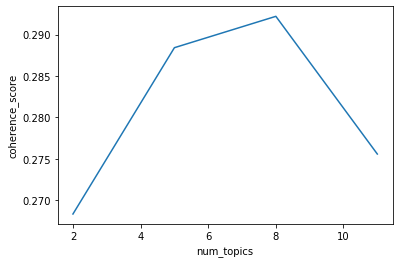

In [32]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

## Findings

- Most of the reviews were centered around batteries and tablets (kindle)
- The reviews' content indicates that a majority of purchases were for children
- Content also indicates that people are happy their kids are happy with the product

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling